In [3]:
import skimage
import skimage.io
import matplotlib.pyplot as plt

import glob
data = [skimage.io.imread(filename) for filename in glob.glob('data/*.tif')]

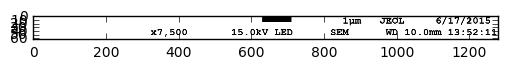

In [4]:
%matplotlib inline
plt.imshow(data[0][960:])

In [10]:
import pytesseract
import PIL.Image
image = PIL.Image.open('data/1045_Steel_Nital-etch-01.tif') #skimage.io.imread(img_as_float(data[0])[...,0])
#image.split()
print(pytesseract.image_to_string(image))

Ea)!

6/1772015
WD 10.0mm 13:16:51
